# Nonlinear regression: Estimating reaction parameters



## Motivation

### What and why
Ready to dive into nonlinear regression? In nonlinear regression models, the relationship between the regression parameters and the outcome variable is nonlinear.  Here are a couple of regression models where the regression parameters $a$, $b$, and $c$ have a nonlinear relationship with the dependent variable $y$:

$$y(x) = a\cdot x^b+c$$
$$y(x) = \dfrac{a\cdot x}{b+x}$$
$$y(x) = \dfrac{a}{1+b^{x-c}}$$

Nonlinear regression is essential in fields with complex relationships, providing flexibility for more accurate modeling. Notable applications include:

- **Biology and Medicine**: Understanding growth rates and enzyme kinetics.
- **Economics**: Analyzing complex demand and price curves.
- **Environmental Science**: Uncovering relationships between crop yields and soil conditions.
- **Physics and Engineering**: Understanding radioactive decay or modeling properties of materials.

These applications benefit from nonlinear regression's ability to deliver more accurate models and retain known model form for predictions and insights, especially in situations where linear regression approaches may fall short.

### The nonlinear regression problem
The goal of nonlinear regression is to find the parameters that minimize the model error, typically measured by the squared error between the model’s predictions,  $y(x_i; \text{regression parameters})$ and the actual data points $y_i$. In optimization terms, this process involves:
- **Decision variables**: The regression parameters (e.g., $a$ and $b$ in our example below) that define the model.
- **Data**: The "variables" from the regression model (e.g., y(x) and x) become data points $y_i$ and $x_i$ for all data points $i$.
- **Objective**: Commonly, we minimize the sum of the squared error between the model predictions $y_{\rm model}(x_i; a, b)$ and observed values $y_i$.  Sometimes, absolute error is used as an alternative.
- **Constraints**: Often, nonlinear regression has no natural constraints, though bounds can be set on parameters as needed. In this exercise we will, we define $y_{\rm model}(x)$ to establish our objective.

Here’s the general form for least squares regression:
\begin{align*}
{\rm minimize}_{a,b} & \quad \displaystyle \sum_{\text{data points }i}   \left(y_\text{model}(x_i; a,b) - y_i\right)^2
\end{align*}

And, if we use our second example model from above $y(x) = \dfrac{a\cdot x}{b+x}$, this would be 
\begin{align*}
{\rm minimize}_{a,b} & \quad \displaystyle \sum_{\text{data points }i}   \left(\dfrac{a\cdot x_i}{b+x_i} - y_i\right)^2
\end{align*}



In many applicaiton such problems are solved using a reduced gradient method that cannot garantee global optimality. In nonlienar regression, it is possible to have multiple local optima because they are typically nonconvex. 

### Comparison to linear regression
Linear regression is often the first and most widely used type of regression, where the relationship between parameters and the predicted value $y(x)$ is linear. For example:
$$y(x) = a\cdot x + b$$
$$y(x) = a\cdot x + b\cdot z + c$$

Even with terms like $x^2$ or $x\cdot e^x$, a regression model can be trained using linear regression as long as the parameters ($a$, $b$, and $c$) are linear with respect to $y(x)$:
$$y(x) = a\cdot xz + b\cdot x^2 + c\cdot z$$
$$y(x) = a\cdot xe^x + b\frac{1}{x} + c$$

This is because, in the optimization model, the regression coefficients $a$, $b$, and $c$ are the actual variables, while the independent and dependent variables, $x$ and $y$ are simply data points rather than variables themselves. So, the use of the word 'variable' in this notebook can get a little tricky! To keep things clear, we’ll refer to the optimization variables as 'decision variables' wherever possible.

Linear regression offers a closed-form solution, allowing parameters to be calculated directly—an advantage that makes it fast in tools like Excel, R, and Python.

Nonlinear regression, however, lacks this simplicity. Instead, we solve an optimization problem to find the parameters. Though more complex, this approach is essential for modeling curved or intricate data relationships, providing a flexible and accurate fit.


In this notebook, we will learn how to write a nonlinear regression model where the goal is to determine the regression parameters that minimize the least squares error.

Here are a few handy resources to have ready:
- [Gurobi Python Documentation](https://docs.gurobi.com/projects/optimizer/en/current/reference/python.html)
- [Gurobi Python Examples](https://docs.gurobi.com/projects/examples/en/current/examples/python.html)

 ## Problem Description 

### Michaelis-Menten Enzyme Kinetics
[Michaelis-Menten](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics) kinetics describes how quickly a reaction happens when an enzyme—a type of molecule that speeds up processes in the body or other reactions—interacts with other molecules. Initially, as the amount of molecules $x$ increases, the reaction speed, $y$, increases. But at a certain point, adding more molecules doesn’t increase the speed much because the enzyme is already working as fast as it can.

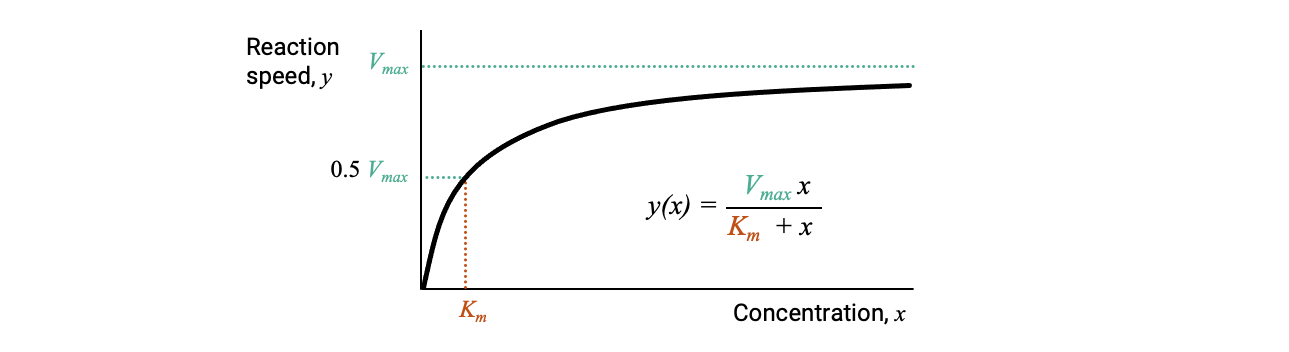

Two key things come from this: the maximum speed the enzyme can reach $V_{max}$ and the concentration level at which it’s working at half that maximum speed $K_m$. These insights help us understand efficiency and limitations, which is valuable for making decisions in fields like drug development, where knowing an enzyme's limits can guide dosage or predict interactions.

In Michaelis-Menten kinetics, we can model the speed of an enzymatic reaction can be with the following equations:

$$
[\text{Speed of reaction}] = \frac{{\bf V_{max}}\cdot [\text{Initial concentration}]}{K_m + [\text{Initial concentration}]}
$$
or
$$
y(x) = \frac{{\bf V_{max}}\cdot x}{K_m + x}
$$

where the regression parameters that we will find in this notebook are $V_{max}$ and $K_m$.  We will be given data points $i$ for 
- The independent variable $x$ which is the concentration. Each data point will be $x_i$.
- The dependent variable $y(x)$ which is the speed of the reaction that we are trying to model.  Each data point will be $y_i$.

## Solution approach

Your goal in this notebook is to write a model to find the optimal regression parameters $V_{max}$ and $K_m$. To achieve this, you will formulate a nonlinear least squares regression problem.


### Let's get started
Throughout the rest of this notebook, you will
1. Define the data
1. Create the Gurobi `model` object
1. Add decision variables
1. Add constraints
1. Set the objective function
1. Solve the model
1. Retrieve solution values

## 0. The obligatory part
This is the obligatory part of all python code: installing and importing packages.  

First, let's install a few packages as needed, then import them

In [ ]:
!pip install gurobipy
!pip install plotly
!pip install numpy
!pip install pandas
!pip install openpyxl

In [ ]:
import gurobipy as gp
from gurobipy import GRB

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

<div class="alert alert-success alert-dismissible">
  <a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
    <strong>Quick Tip</strong>
    <p>The first two import lines above will be needed each time you want to use gurobipy. You are encouraged to completely forget this part and copy-and-paste it for each new Gurobi model you write  ;).</p>
</div>

---

## 1.  Load and visualize data

In this section, we will read in the benchtop experimental data that we will use to train our model.  We will be given 10 data values for $x$ and $y$.


In [ ]:
# Data
path = 'https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization202/Modeling_Session_1/'
df = pd.read_excel(path + 'MMdata.xlsx') 

# Use the gurobipy multidict structure to unpack the data in our data frame
# Data is from https://cran.r-project.org/web/packages/renz/vignettes/dirMM.html
points, xtrain, ytrain = gp.multidict({
        row['index']: [float(row['x']), float(row['y'])] for ind,row in df.iterrows()
    }) 

# Show the data:
print("Here are the x values:")
print(xtrain)

print("\nHere are the y values:")
print(ytrain)

### View the data points

In [ ]:
# Create a figure
fig = go.Figure()
xtrain_arr = np.array(list(xtrain.values()))
ytrain_arr = np.array(list(ytrain.values()))

# Add the first line
fig.add_trace(go.Scatter(x=xtrain_arr, y=ytrain_arr, mode='markers', name='Training data'))

# Update layout 
fig.update_layout(title='Nonlinear regression example: Reaction Speed vs Concentration',
                  xaxis_title='x',
                  yaxis_title='y',
                  template='simple_white')
# Show the figure
fig.show()

---

## 2. Begin building the model
In the next four steps, we will be creating the following model:
$$
\begin{align*}
{\rm minimize} &  \quad \displaystyle \sum_{\text{data points }i}   \left(y_{\text{model},i} - y_i\right)^2 \\ \\
{\rm s.t.} & \quad y_{\text{model},i} =  \frac{{\bf V_{max}}\cdot x_i}{K_m + x_i} & \forall \text{ data points }i  \\ 
\end{align*}
$$


where we have:
- **Decision variables**: The main decision variables are regression parameters $V_\text{max}$ and $K_m$. We are also creating and defining variables for each prediction value $y_{\text{model},i}$
- **Data**: Observation data points $x_i$ and $y_i$
- **Constraints**: We have a constraints for every data point $i$ to definte the prediction value $y_{\text{model},i}$
- **Objective**: We are minimizing the sum of the squared error

We will also add bounds to all of our variables as it is a best practice --- and makes the model run MUCH faster.


To start, we will need to create the [model()](https://docs.gurobi.com/projects/optimizer/en/current/reference/python/model.html) object in Gurobi.  The Model object holds a single optimization problem. It consists of a set of variables, a set of constraints, and an objective function.

In [ ]:
# Declare and initialize model
model = gp.Model("Nonlinear regression")

---

## 3. Add Decision variables
The main decision variables are regression parameters $V_\text{max}$ and $K_m$ (in your model, name these `Vmax` and `Km`). We are also creating and defining each prediction value $y_{\text{model},i}$ for every data point $i$.

**Bounding the decision variables**: Providing bounds on the variables is important for model performance. In our case, you can assume that $V_\text{max}$ and $K_m$ will each be between zero and 1000. For each $y_{\text{model},i}$, you can use a lower bound of $-2 * y_\max$ and an upper bound of $2*y_\max$ where $y_\max$ is the largest reaction time.

In [ ]:
# Create decision variables 
# Vmax = model.addVar(...) #complete the code
# Km = model.addVar(...)

# Create additional variables to define the model
ymax = max(ytrain.values()) # Used in a thoughtful upper bound on ymodel
# (your code goes here)

<div class="alert alert-success alert-dismissible">
  <a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
    <strong>Quick Tip</strong>
    <p>Remember to bound your variables where possible.  This helps encourage a speedy solve.</p>
</div>

Next, let's double check the variables look like we would expect.

In [ ]:
# Check your work by printing out the variables
model.update()
print("The model variables are: ")
for v in model.getVars():
    print(f" - {v.varname} with lower bound of {v.lb} and upper bound of {v.ub}")

---
## 4. Add Constraints
We will begin adding the constraints that define our problem. For this model, all we need to do is define $y_{\text{model},i}$, where
$$y_{\text{model},i} = \frac{{\bf V_{max}}\cdot x_i}{K_m + x_i}  \quad  \quad \forall \text{ data points }i$$

In [ ]:
# Write out your constraint to define ymodel[i] for each data point in points
# (your code goes here)

<div class="alert alert-success alert-dismissible">
  <a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
    <strong>Quick Tip</strong>
    <p>Remember to think about reformulating your equations.  This constraint could easily be written in two ways. </p>
    <p>Option 1:</p>
    <pre>ymodel[i] = Vmax*x[i] / (Km + x[i])</pre>
    <p></p>
    <p>Option 2:</p>
    <pre>ymodel[i](Km + x[i]) = Vmax*x[i] </pre>
    <p></p>
    <p>The second option would be easier for the solver to use because it is a quadratic equation rather than a fully nonlinear one.</p>
</div>


---
## 5. Set the objective
The goal is to minimize the least squared error. In this step, we will write the following objective
$$
\begin{align*}
{\rm minimize} &  \quad \displaystyle \sum_{\text{data points }i}   \left(y_{\text{model},i} - y_i\right)^2 
\end{align*}
$$

In [ ]:
# Write the objective
# (your code goes here)

### Celebrate and check your work

In [ ]:
model.write('nonlinear_regression.lp')

<div class="alert alert-success alert-dismissible">
  <a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
    <strong>Quick Tip</strong> 
    <p>In the cell above, we wrote out the model as an LP file.  This is a human-readable format that can allow you to check to make sure your constraints and objectives look right.  This has been saved to this local directory.  
    <p>Take a look at nonlinear_regression.lp. Does everything look correct?  If so, please consider celebrating. Think about all the enzymatic reactions happening in your body. Go eat a donut -- make more reactions.</p>
</div>

<a id='6_optimize'></a>
---
## 6. Solve the model 
We use the [optimize()](https://www.gurobi.com/documentation/current/refman/py_model_optimize.html) method of the Gurobi/Python API to solve the problem we have defined for the model object `model`.

In [ ]:
model.optimize()

**Question**: Look at the Gurobi log and reflect on what you see. What type of model was this? Was it convex or non-convex? Is this consistent with what you would expect?  

### Check your solution

In [ ]:
status = model.status
if status == GRB.OPTIMAL:
    print(f"An optimal solution was found with objective {model.objVal}")
    model.printAttr('X')
else:
    print(f"Model is not optimal, status = {status}")

---
## 7. View the solution
In the next section, we will plot our resulting regtession model alongside the data.  

We pulled this data from [dirMM - Fitting the Michaelis-Menten Model](https://cran.r-project.org/web/packages/renz/vignettes/dirMM.html).  This R package also gives its values for $V_\text{max} = 181.182$ and $K_m=3.115$. As you can see our values may differ from this.  Let's plot them and see which looks better.  I have also calculated the Mean Squared Error (MSE) for both lines and added it to the chart.

In [ ]:
# Create a figure
def ylist_MM(xlist, Vmax, Km):
    return [Vmax*x/(Km + x) for x in xlist]
def mean_squared_error(xlist, ylist, Vmax, Km):
    y = ylist_MM(xlist, Vmax, Km)
    return np.sum((y-ylist)**2)/len(xlist)

# Create a figure
fig = go.Figure()
xtrain_arr = np.array(list(xtrain.values()))
ytrain_arr = np.array(list(ytrain.values()))
xplot = np.linspace(min(xtrain_arr), max(xtrain_arr), 100)

# Add the first line
fig.add_trace(go.Scatter(x=xtrain_arr, y=ytrain_arr, mode='markers', name='Training data'))

# Add the second line
label = "dir-MM (R-method)"
this_Vmax = 181.18
this_Km = 3.115
MSE = mean_squared_error(xtrain_arr, ytrain_arr, this_Vmax, this_Km)
fig.add_trace(go.Scatter(x=xplot, y=ylist_MM(xplot,this_Vmax, this_Km), mode='lines', name=f"{label}: Vmax={round(this_Vmax,1)}, Km={round(this_Km,1)} (MSE={round(MSE,1)})"))

# Add the second line
label = "Gurobi"
MSE = mean_squared_error(xtrain_arr, ytrain_arr, Vmax.X, Km.X)
fig.add_trace(go.Scatter(x=xplot, y=ylist_MM(xplot,Vmax.X, Km.X), mode='lines', name=f"{label}: Vmax={round(Vmax.X,1)}, Km={round(Km.X,1)} (MSE={round(MSE,1)})"))


# Update layout (optional)
fig.update_layout(title='Nonlinear regression example: Reaction Speed vs Concentration',
                  xaxis_title='x',
                  yaxis_title='y',)
fig.update_layout(template='simple_white')
# Show the figure
fig.show()

## Before you exit, free up Gurobi resources
After you are done, it is a best practice to free up any Gurobi resources associated with the model object and environment.  This will release any shared licenses and end the job on the cloud or compute server.  

To do this, call [Model.dispose()](https://www.gurobi.com/documentation/current/refman/py_model_dispose.html#pythonmethod:Model.dispose) on all Model objects, [Env.dispose()](https://www.gurobi.com/documentation/current/refman/py_env_dispose.html#pythonmethod:Env.dispose) on any Env objects you created, or [disposeDefaultEnv()](https://www.gurobi.com/documentation/current/refman/py_disposedefaultenv.html#pythonmethod:disposeDefaultEnv) if you used the default environment instead.

In [ ]:
# Free Gurobi resources: Model and environment
model.dispose()
gp.disposeDefaultEnv()